In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pathlib import Path
from typing import Iterable, Tuple, List, Any
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Начнем изучение NLP с понятной задачи - предсказание сантимента.

## Prepare Data [2 балла]

- Для начала необходимо преобразовать данные
- Напишите функцию, которая читает файл и возвращает объект класса SentimentData (Постарайтесь сделать функцию-итератор, которая бы не клала объекты в память)
- Напишите функцию preprocess (минимальный объем препроцессинга в комментарии к функции)

In [9]:
data_path = Path('/content/drive/MyDrive/Colab Notebooks/animal-crossing_reviews.csv')

In [10]:
from dataclasses import dataclass

@dataclass
class SentimentData:
    sentence: str
    sentiment: int

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

In [11]:
wl = WordNetLemmatizer()

In [ ]:
def extract_lines(path: Path) -> Iterable[SentimentData]:
    with open(path) as src:
        reader = csv.reader(src, delimiter=',')
        next(reader, None)
        data = []
        for row in reader:
          data.append(SentimentData(row[2], int(row[0])))

        return data

extract_lines(data_path)[0]

In [13]:
import string
def preprocess(lines: Iterable[SentimentData]) -> Iterable[str]:
    """
    - Lowercase sentence
    - Do tokenization with nltk.wordpunct_tokenize
    - normalize words
    - delete stop words
    - join using tokens with space
    - yield it to next generator
    """
    for line in lines:
      words = nltk.wordpunct_tokenize(line.sentence.lower())
      words_lem = map(wl.lemmatize, words)
      words_filtered = filter(lambda w: (w not in stop_words) and (w not in string.punctuation), words_lem)
      yield SentimentData(' '.join(words_filtered), line.sentiment)



In [126]:
writer = extract_lines(data_path)
preprocessed = preprocess(writer)

In [127]:
sentences = list(preprocessed)

In [128]:
assert [sent.sentence for sent in sentences[::1000]] == ['gf started playing option create island guy 2nd player start console suck !!!! miss much 1st player get term activity resource etc absolutely terrible buy 2nd console one person household want get full game experience unacceptable',
                                                         'game undeniably adorable super fun unless like second player switch system game lock consequential decision wait player one progress passive resident island way get full experience another switch system absolutely acceptable ha destroyedthis game undeniably adorable super fun unless like second player switch system game lock consequential decision wait player one progress passive resident island way get full experience another switch system absolutely acceptable ha destroyed fun wa game .… expand',
                                                         'sad find second player like slave first player stop playing get fixed']

- Пора разбить данные на тренировочную и тестовую выборку

In [224]:
train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

In [225]:
def split_on_x_y(data: List[SentimentData]) -> Tuple[List[str], List[int]]:
    X, y = [], []
    for d in data:
      X.append(d.sentence)
      y.append(int(d.sentiment >= 4))
    return X, y

In [226]:
X_train, y_train = split_on_x_y(train_data)
X_test, y_test = split_on_x_y(test_data)

## TFIDF + Logistic Regression [2 балла]

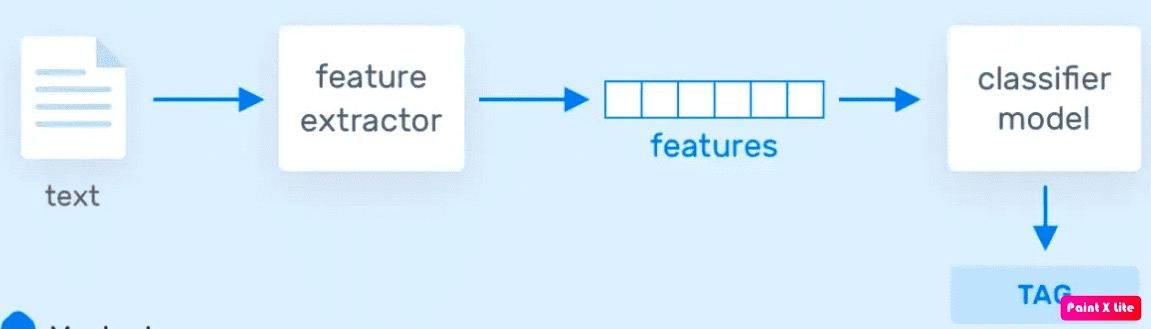

#### TF-IDF
$TF$ - частота встречания терма (term frequency)<br>
$IDF$ - обратная частота встречания терма в документах (invert document frequency)

$$tf_{i, j} = \frac{N_i}{\sum\limits_j N_j}$$<br>
$$idf_{i} = log(\frac{|D|}{|\{d_k \in D | i \in d_k \}|}) \approx log (\frac{|D|}{df(i) + 1}) \approx log (\frac{|D| + 1}{df(i) + 1}) + 1$$

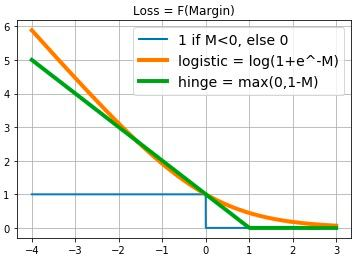

$$Q(w) = \sum_{i = 0}^{|D|} log(1 + exp(-y_i<x_i * w>)) -> min_w$$ - функция потерь

$$p(y|x) = \sigma(x,w) = \frac{1}{1 + e^{-xw}}$$ - апостериорная вероятность класса

- Создайте sklearn'вский pipeline с предобработкой текста и LogisticRegression
- Добавьте GridSearchCV для настройки коэффициентов LR

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85       316
    positive       0.86      0.77      0.81       284

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



In [ ]:
param_grid = {
    'classifier__C': [0.1, 0.5, 1, 2, 5, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=50, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=50,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1, param_grid={'classifier__C': [0.1, 0.5, 1, 2, 5, 10]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'classifier__C': 1}

- Если Вы никогда не имели дело с PyTorch, то переходим в ноутбук PyTorch Intro.ipnyb

## Going to Pytorch [2 балла]

- Давайте создадим кастомный датасет для удобной загрузки данных

In [41]:
from torch.utils.data import Dataset
class CustomTagDataset(Dataset):
    """
    - CustomTagDataset должен быть наследником torch.utils.data.Dataset, чтобы в полной мере наследовать все возможности
    - Датасет должен принимать sentences: List[str], target: List[int] и feature_extractor: Pipeline - pipeline для выделения признаков из текста
    - Напишите функцию __len__ объявляющие длину вашего датасета
    - Напишите функцию _extract_features
    - Напишите функцию __getitem__ которая будет по индексу возвращаться словарь {'feat': tensor_of_features, 'target': tensor_of_target} все dtype=torch.float

    """
    def __init__(self, sentences: List[str], target: List[int], feature_extractor: Pipeline, test: bool = False):
        self._data = sentences
        self._target = target
        self._features_pipeline = feature_extractor
        self._features = self._extract_features(test)

    def __getitem__(self, idx: int):

        return {
            "feat": self._features[idx],
            "target": self._target[idx]
        }

    def _extract_features(self, is_test):
        if is_test:
            return torch.Tensor(self._features_pipeline.transform(self._data).toarray())
        else:
            return torch.Tensor(self._features_pipeline.fit_transform(self._data).toarray())

    def __len__(self):
        return len(self._data)

In [227]:
from torch.utils.data import DataLoader
features = Pipeline(
    [
        ('vectorize', CountVectorizer()),
        ('tfidf', TfidfTransformer())
    ]
)

data_train = DataLoader(CustomTagDataset(X_train, y_train, features, test=False), batch_size=16, shuffle=True)
data_test = DataLoader(CustomTagDataset(X_test, y_test, features, test=True), batch_size=16, shuffle=True)

In [221]:
class SimpleNNForClassification(nn.Module):
    """
    - Напишите слои нейронной сети
      - Линейный слой из tfidf_feature_size в in_features
      - ReLU
      - Линейный слой преобразующий in_features в out_features
      - ReLU
      - Линейный слой преобразующий out_features в тензор размера 1
    - Напишите forward
    """
    def __init__(self, tfidf_feature_size: int, in_features=100, out_features=100):
        super(SimpleNNForClassification, self).__init__()
        self.layer1 = nn.Linear(tfidf_feature_size, in_features)
        self.layer2 = nn.Linear(in_features, out_features)
        self.fc =  nn.Linear(out_features, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))

        return self.fc(x)

In [109]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cpu')

### Обучение и оценка качества получившейся модели [1 балл]

In [187]:
@torch.no_grad()
def print_metrics(model, test_data):
    """
    - напишите часть инференса
      - передайте в модель батч с признаками
      - чтобы превратить logit-вектора в 'вероятности' примените сигмоидную функцию
      - посчитайте получившиеся значения сантиментов с помощью трешхолда = 0.5
    """
    preds = []
    target = []
    sigm = nn.Sigmoid()
    for i, batch in tqdm.notebook.tqdm(enumerate(test_data)):
        prob = sigm(model(batch['feat']))
        preds +=  (prob.squeeze()>=0.5).type(torch.long).tolist()
        target += batch['target'].type(torch.long)
    print(classification_report(target, preds, target_names=["negative", "positive"]))

In [185]:
def train(model: nn.Module,
          train_data: List[Any],
          test_data: List[Any] = None,
          epochs: int = 5,
          batch_size: int = 16,
          regularization = 0):
    """
    - напишите часть обучения для модели
      - передайте в модель батч с признаками
      - посчитайте лосс
      - вызовите backward propagation
    """

    model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=regularization)

    if test_data is not None:
        print_metrics(model, test_data)

    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm.notebook.tqdm(enumerate(train_data)):
            pred = model(batch['feat'])
            loss = criterion(pred.squeeze(), batch['target'].type(torch.float))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if test_data is not None:
            print_metrics(model, test_data)


In [228]:
model = SimpleNNForClassification(features["tfidf"].idf_.shape[0])
train(model, data_train, data_test, epochs=10)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       316
    positive       0.47      1.00      0.64       284

    accuracy                           0.47       600
   macro avg       0.24      0.50      0.32       600
weighted avg       0.22      0.47      0.30       600

epoch: 0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85       316
    positive       0.85      0.80      0.83       284

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

epoch: 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.81      0.86      0.83       316
    positive       0.83      0.78      0.80       284

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

epoch: 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       316
    positive       0.85      0.75      0.80       284

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

epoch: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.82      0.79      0.81       316
    positive       0.78      0.81      0.79       284

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

epoch: 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.86      0.83       316
    positive       0.83      0.77      0.80       284

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

epoch: 5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       316
    positive       0.82      0.77      0.79       284

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

epoch: 6


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       316
    positive       0.82      0.77      0.79       284

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

epoch: 7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       316
    positive       0.82      0.77      0.79       284

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

epoch: 8


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.80      0.85      0.82       316
    positive       0.82      0.77      0.79       284

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

epoch: 9


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.81      0.84      0.83       316
    positive       0.82      0.78      0.80       284

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600



### Prevent Overfitting [3 балла]

- Как видно выше модель очень быстро переобучается, так давайте применим все те широкоизвестные методы, чтобы этого избежать
- Считайте качество на валидационной выборке
- Можете воспользоваться Early Stopping'ом
- Добавить регуляризацию в модель
- Все что Ваша фантазия позволяет - делайте

In [229]:
train_, val_ = train_test_split(train_data, test_size=0.2, random_state=42)
X_train, y_train = split_on_x_y(train_)
X_val, y_val = split_on_x_y(val_)

In [230]:
data_train = DataLoader(CustomTagDataset(X_train, y_train, features, test=False), batch_size=64, shuffle=True)
data_val = DataLoader(CustomTagDataset(X_val, y_val, features, test=True), batch_size=64, shuffle=True)
data_test = DataLoader(CustomTagDataset(X_test, y_test, features, test=True), batch_size=64, shuffle=True)

In [249]:
class SimpleNNForClassification2(nn.Module):
    """
    - Напишите слои нейронной сети
      - Линейный слой из tfidf_feature_size в in_features
      - ReLU
      - Линейный слой преобразующий in_features в out_features
      - ReLU
      - Линейный слой преобразующий out_features в тензор размера 1
    - Напишите forward
    """
    def __init__(self, tfidf_feature_size: int, in_features=100, out_features=100):
        super(SimpleNNForClassification2, self).__init__()
        self.layer1 = nn.Linear(tfidf_feature_size, in_features)  # добавили batch нормализацию
        self.layer2 = nn.Linear(in_features, out_features)
        self.fc =  nn.Linear(out_features, 1)
        self.bn1 = nn.BatchNorm1d(in_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.bn1(self.layer1(x)))
        x = self.act(self.bn2(self.layer2(x)))

        return self.fc(x)

In [250]:
model1 = SimpleNNForClassification2(features["tfidf"].idf_.shape[0])
train(model1, data_train, data_val, regularization=1e-2)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.55      0.55      0.55       262
    positive       0.46      0.46      0.46       218

    accuracy                           0.51       480
   macro avg       0.51      0.51      0.51       480
weighted avg       0.51      0.51      0.51       480

epoch: 0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       262
    positive       0.87      0.83      0.85       218

    accuracy                           0.87       480
   macro avg       0.87      0.87      0.87       480
weighted avg       0.87      0.87      0.87       480

epoch: 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       262
    positive       0.82      0.82      0.82       218

    accuracy                           0.84       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.84      0.84      0.84       480

epoch: 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       262
    positive       0.82      0.82      0.82       218

    accuracy                           0.84       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.84      0.84      0.84       480

epoch: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86       262
    positive       0.82      0.84      0.83       218

    accuracy                           0.85       480
   macro avg       0.84      0.85      0.84       480
weighted avg       0.85      0.85      0.85       480

epoch: 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       262
    positive       0.84      0.84      0.84       218

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480



In [251]:
print_metrics(model1, data_test)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.81      0.87      0.84       316
    positive       0.85      0.77      0.81       284

    accuracy                           0.83       600
   macro avg       0.83      0.82      0.83       600
weighted avg       0.83      0.83      0.83       600



Добавил batch_norm и регуляризацию=0.01

### Beat Logistic Regression [3 балла]

- Задание одной картинкой

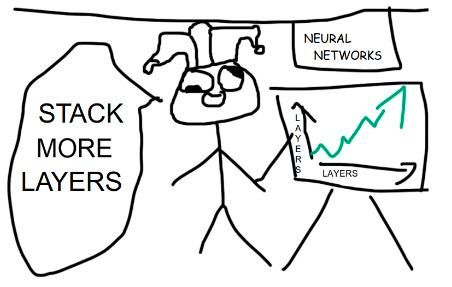

На самом деле нет
- Подумайте как можно улучшить выделение признаков из текста (лемматизация, стемминг, tf-idf от нграмм - всё в ваших руках)
- Stack More Layers

In [243]:
class ResSimpleNNForClassification(nn.Module):
    """
    - Напишите слои нейронной сети
      - Линейный слой из tfidf_feature_size в in_features
      - ReLU
      - Линейный слой преобразующий in_features в out_features
      - ReLU
      - Линейный слой преобразующий out_features в тензор размера 1
    - Напишите forward
    """
    def __init__(self, tfidf_feature_size: int, in_features=100, out_features=100):
        super(ResSimpleNNForClassification, self).__init__()
        self.layer1 = nn.Linear(tfidf_feature_size, in_features)  # добавили batch нормализацию
        self.layer2 = nn.Linear(in_features, out_features)
        self.layer3 = nn.Linear(out_features, out_features)  # добавили batch нормализацию
        self.layer4 = nn.Linear(out_features, out_features)
        self.fc =  nn.Linear(out_features, 1)
        self.bn1 = nn.BatchNorm1d(in_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.bn3 = nn.BatchNorm1d(out_features)
        self.bn4 = nn.BatchNorm1d(out_features)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.bn1(self.layer1(x)))
        x = self.act(self.bn2(self.layer2(x)))
        x = self.act(self.bn3(self.layer3(x)))
        x = self.act(self.bn4(self.layer4(x)))

        return self.fc(x)

In [247]:
model2 = ResSimpleNNForClassification(features["tfidf"].idf_.shape[0])
train(model2, data_train, data_val, regularization=3e-4,epochs=10)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.52      0.29      0.38       262
    positive       0.44      0.68      0.54       218

    accuracy                           0.47       480
   macro avg       0.48      0.49      0.46       480
weighted avg       0.49      0.47      0.45       480

epoch: 0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       262
    positive       0.87      0.82      0.85       218

    accuracy                           0.86       480
   macro avg       0.87      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480

epoch: 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86       262
    positive       0.82      0.83      0.83       218

    accuracy                           0.84       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.84      0.84      0.84       480

epoch: 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.83      0.84       262
    positive       0.80      0.82      0.81       218

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480

epoch: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       262
    positive       0.82      0.83      0.82       218

    accuracy                           0.84       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.84      0.84      0.84       480

epoch: 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86       262
    positive       0.83      0.83      0.83       218

    accuracy                           0.85       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.85      0.85      0.85       480

epoch: 5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.84      0.85       262
    positive       0.81      0.82      0.82       218

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480

epoch: 6


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       262
    positive       0.84      0.84      0.84       218

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480

epoch: 7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86       262
    positive       0.82      0.84      0.83       218

    accuracy                           0.85       480
   macro avg       0.84      0.85      0.84       480
weighted avg       0.85      0.85      0.85       480

epoch: 8


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86       262
    positive       0.83      0.85      0.84       218

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480

epoch: 9


0it [00:00, ?it/s]

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86       262
    positive       0.83      0.83      0.83       218

    accuracy                           0.85       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.85      0.85      0.85       480



In [248]:
print_metrics(model2, data_test)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.82      0.89      0.85       316
    positive       0.86      0.79      0.82       284

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



Добавил ещё слоёв, поигрался с regularization